# University of Applied Sciences Munich
## Kalman Filter Tutorial

---
(c) Lukas Köstler (lkskstlr@gmail.com)

In [2]:
import ipywidgets as widgets
from ipywidgets import interact_manual
from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 3)

import numpy as np
%matplotlib notebook

In [2]:
def normal_pdf(x, mu=0.0, sigma=1.0):
    return 1.0 / np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5/sigma**2 * (x-mu)**2)

#### Possible sources:
+ (One of the most prominent books on robotics) https://docs.ufpr.br/~danielsantos/ProbabilisticRobotics.pdf
+ (Many nice pictures) http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
+ (Stanford lecture slides) https://stanford.edu/class/ee363/lectures/kf.pdf


## Kalman Filter in Multiple Dimensions
---
* The concept is exactly the same, just the math looks more difficult.
* Just use the equations given in a book/paper/wikipedia

### Transition Model
---
\begin{align}
\mathbf{x}_{n+1} = A \mathbf{x}_n + B \mathbf{u}_{n+1} + error
\end{align}


with $\mathbf{x} \in \mathcal{R}^{d_x}, \mathbf{u} \in \mathcal{R}^{d_u}, A \in \mathcal{R^{d_x,d_x}}, B \in \mathcal{R^{d_x,d_u}}$. And $error \sim N \left( 0, R \right)$ and $R \in \mathcal{R^{d_x,d_x}}$

### Measurement Model
---
\begin{align}
\mathbf{z}_{n} = C \mathbf{x}_n + error
\end{align}


with $\mathbf{z} \in \mathcal{R}^{d_z}, C \in \mathcal{R^{d_z,d_x}}$. And $error \sim N \left( 0, Q \right)$ and $Q \in \mathcal{R^{d_z,d_z}}$

### Algorithm (1/2)
---
\begin{align}
\text{mean:} && \mathbf{\mu}_n \\
\text{covariance:} && \Sigma_n \\
\text{pred. mean:} && \mathbf{\mu}_{n+1 \vert n} \\
\text{pred. cov:} && \Sigma_{n+1 \vert n}\\
\text{kalman gain:} && K_n
\end{align}


with $\mathbf{\mu} \in \mathcal{R}^{d_x}, \Sigma \in \mathcal{R}^{d_x, d_x}, K \in \mathcal{R}^{d_x, d_z}$

### Algorithm (2/2)
---
\begin{align}
\mathbf{\mu}_{n+1 \vert n} &= A \mathbf{\mu}_n + B \mathbf{u}_{n+1} \\
\Sigma_{n+1 \vert n} &= A \Sigma_n A^T + R \\
K_{n+1} &= \Sigma_{n+1 \vert n} C^T \left(C \Sigma_{n+1 \vert n} C^T + Q \right)^{-1} \\
\mathbf{\mu}_{n+1 \vert n+1} &= \mathbf{\mu}_{n+1 \vert n} + K_{n+1} \left( z_{n+1} - C \mathbf{\mu}_{n+1 \vert n}\right) \\
\Sigma_{n+1} &= \left(I - K_{n+1} C \right) \Sigma_{n+1 \vert n}
\end{align}

## Let's try this:
---
* Example: robot localization on a 2D map in mind
 \begin{equation}
 \mathbf{x}_n = \begin{bmatrix}
 x \\
 y \\
 \varphi
 \end{bmatrix}
 \end{equation}
 Note: $\mathbf{x}_n$ is the state and $x$ is the vehicles position in the plane. Sorry for the confusing nomenclature.
* The control at time $t_n$ is denoted $\mathbf{u}_n$. This could be
 \begin{equation}
 \mathbf{u}_n = \begin{bmatrix}
 v \\
 \omega \\
 \end{bmatrix}
 \end{equation}
 with $v$ the velocity of the car and $\omega$ the angular velocity of the car (or more precisely of the velocity vector).

### Transition Model
---
* Remember
$$ \mathbf{x}_{n+1} = A \mathbf{x}_n + B \mathbf{u}_{n+1} $$

* Simplest possible form of motion (by far not the best. Use the models in Thrun et. al: Probabilistic Robotics):
\begin{align}
\mathbf{x}_{n+1} = \begin{bmatrix}
 x_{n+1} \\
 y_{n+1} \\
 \varphi_{n+1}
 \end{bmatrix}
 =
 \mathbf{x}_n + 
 \begin{bmatrix}
 v \Delta t \, cos(\varphi_n) \\
 v \Delta t \, sin(\varphi_n) \\
 \Delta t \, \omega
 \end{bmatrix}
\end{align}

* This is not linear :(

## To the rescue: Extended Kalman Filter
---
* What we want:
$$ \mathbf{x}_{n+1} = A \mathbf{x}_n + B \mathbf{u}_n $$

* What we have:
\begin{equation}
\mathbf{x}_{n+1} = \underbrace{f\left(\mathbf{x}_{n}, \mathbf{u}_{n}\right)}_{\text{non-linear function}}
\end{equation}

* Remedy: Taylor Expansion

## Taylor Expansion
---
* A function can be approximated by it's derivatives (actually much more theory but we do not care)
* So:
\begin{align}
f(x) &= f(x_0) + \frac{df}{dx}(x_0) (x-x_0) + O(x^2) \\[1.3ex]
     &= f(x_0) + f'(x_0) (x-x_0) + \dots
\end{align}


* Example: $f(x) = sin(x) \rightarrow f'(x) = cos(x)$, $x_0 = 0$:
\begin{align}
f(x) &= f(x_0) + f'(x_0) (x-x_0) + O(x^2) \\[1.3ex]
     &= 0 + 1 (x-0) + \dots \\[1.3ex]
     &= x
\end{align}

In [6]:
%%capture
xx = np.linspace(-2,2,1000)
fig = plt.figure()
plt.plot(xx, np.sin(xx), label="$f(x) = sin(x)$")
plt.plot(xx, xx, '--', label="$f(x) = x$")
plt.legend()
plt.title("First Order Taylor Expansion of $sin(x)$")

<IPython.core.display.Javascript object>


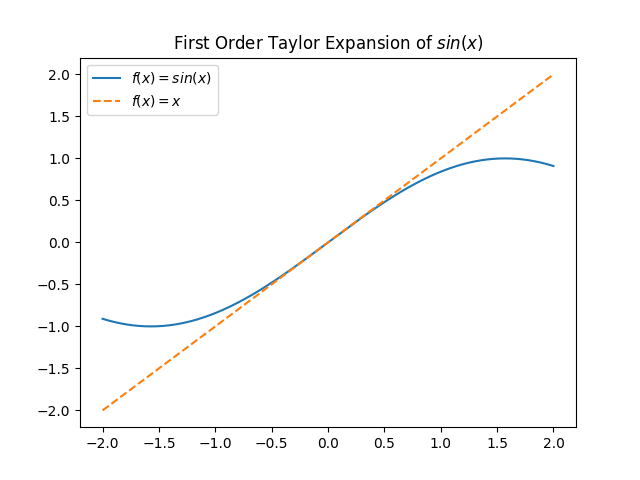

In [7]:
display(fig)

## Taylor Expansion
---
* This also works in higher dimensions. The derivative is replaced with the jacobi matrix:
\begin{align}
f(\mathbf{x}) &= f(\mathbf{x}_0) + A (\mathbf{x}-\mathbf{x}_0) + O(\vert \vert x \vert \vert ^2) \\[1.3ex]
A &= \frac{d}{d \mathbf{x}} f (\mathbf{x}_0)\\[1.3ex]
\phantom{1}
\end{align}

* And this gives us the linear equation we need!

## Extended Kalman Filter
---
* In each step linearize around the current mean and use the linear Kalman equations explained before
* Let's do an example!

## Extended Kalman Filter
---
* In each step linearize around the current mean and use the linear Kalman equations explained before
* Let's do an example!

## EKF Localization
---

from Probabilistic Robotics chapter 7.5
* State:
\begin{equation}
 \mathbf{x}_n = \begin{bmatrix}
 x \\
 y \\
 \theta
 \end{bmatrix}
 \end{equation}
 $x, y$ positions on the map. $\theta$ angle between the forward direction and the global $x$ axis.

* Control:
\begin{equation}
 \mathbf{u}_n = \begin{bmatrix}
 v \\
 \omega
 \end{bmatrix}
 \end{equation}
 $v$ is the velocity in forward direction. $\omega$ is the rotational velocity of the forward direction.

* Perfect Motion Model (I will do a lengthy derivation on the black board):
\begin{equation}
 \mathbf{x'} = \begin{bmatrix}
 x' \\
 y' \\
 \theta'
 \end{bmatrix}
 =
 \begin{bmatrix}
 x \\
 y \\
 \theta
 \end{bmatrix}
 +
 \begin{bmatrix}
 r \left( - sin \theta + sin \left(\theta + \omega \Delta t\right)\right) \\
 r \left( + cos \theta - cos \left(\theta + \omega \Delta t\right)\right) \\
 \omega \Delta t
 \end{bmatrix}
 =:
 g \left(\mathbf{x}, \mathbf{u}\right)
 \end{equation}
 
* $r$ is the radius of the circle on which the robot moves with velocity $v$. Out of the triple $v, r, \omega$ two can be choosen and the last one obtained by calculation, e.g. $r = v / \omega$

* Let's linearize this for the EKF: $g \left(\mathbf{x}_n, \mathbf{u}_{n+1}\right) \approx g \left(\mathbf{\mu}_n, \mathbf{u}_{n+1}\right) + A \left( \mathbf{x}_n - \mathbf{\mu}_n \right)$


\begin{equation}
 A = \begin{bmatrix}
 1 & 0 & r \,cos \left(\theta_n\right) - r \,cos \left(\theta_n + \omega_{n+1} \Delta t\right) \\
 0 & 1 & r \,sin \left(\theta_n\right) - r \,sin \left(\theta_n + \omega_{n+1} \Delta t\right) \\ 
 0 & 0 & 1
 \end{bmatrix}
 \end{equation}
 
* For $g \left(\mathbf{\mu}_n, \mathbf{u}_{n+1}\right)$ just insert into the equations from above.

* Measurement (Again: derivations will be done on the blackboard):
* The resulting algorithm is given in the following (table taken from Probabilistic Robotics by Thrun et al)
![EKFLocalization](Table72fromProbabilisticRobotics.png)

### Where to go from here? (1/2)
* Also estimate the positions of the landmarks -> SLAM
* Fast SLAM: [link](http://robots.stanford.edu/papers/Montemerlo03a.html)
* Many good algorithms at openslam: [link](https://openslam.org)
* MRPT seems to offer a ros package which fits exactly (2D Landmarks with range and bearing): [link](http://wiki.ros.org/mrpt_slam)
* Might be difficult to incorporate own motion model. Might also not be necessary.
* Visual Methods:
 * ORB SLAM (ETH): [link](https://github.com/raulmur/ORB_SLAM2)
 * LSD SLAM (TUM): [link](https://github.com/tum-vision/lsd_slam)
 * Calibrate your camera: [link](https://github.com/ethz-asl/kalibr)
 * Might need some thinking in how to integrate the cones; Maybe use SLAM for localization and run own algorithm for cones on top (state is only the cone locations)
* Also global optimization (in time), sometimes called bundle adjustement, might be nice. [g2o](http://wiki.ros.org/g2o) is a nice package for this

### Where to go from here? (2/2)
* The Unscented Kalman Filter does not need derivatives and is thus ways easier to use
* Particle Filters do also not use derivatives but they are much more expensive
* Grid based filters can be very fast on GPUs (and CPUs) and offer a good solution to the localization problem. In my opinion cones on a plane don't really need a grid